<a href="https://colab.research.google.com/github/ArminD93/Intel-Image-Classification/blob/dev/Intel_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Intel Image Classification**




In [4]:
%tensorflow_version 2.x
import os
import time
from datetime import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil # Pomaga w kopiowaniu plików
import seaborn as sns
sns.set(style="ticks", color_codes=True)

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, concatenate, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

np.set_printoptions(precision=12, suppress=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%load_ext tensorboard

In [0]:
!unzip -q "/content/drive/My Drive/ColabNotebooks/intel_image/data/intel_image.zip" 

In [5]:
!rm -rf ./images

base_dir = './intel_image' # Przypisujemy katalog bazowy

raw_no_of_files = {}

classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
for dir in classes: # ile mamy zdjęć dla poszczególnych klas
    raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('buildings', 2628), ('forest', 2745), ('glacier', 2957), ('mountain', 3037), ('sea', 2784), ('street', 2883)])

In [0]:
# Utworzenie katalogów train, test, valid
data_dir = './images' # Przypisujemy katalog bazowy

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')    # katalog dla zbioru treningowego
valid_dir = os.path.join(data_dir, 'valid')    # katalog dla zbioru walidacyjnego
test_dir = os.path.join(data_dir, 'test')      # katalog dla  zbioru testowego

# Wskażemy klasy
train_buildings_dir = os.path.join(train_dir, 'buildings')
train_forest_dir = os.path.join(train_dir, 'forest')
train_glacier_dir = os.path.join(train_dir, 'glacier')
train_mountain_dir = os.path.join(train_dir, 'mountain')
train_sea_dir = os.path.join(train_dir, 'sea')
train_street_dir = os.path.join(train_dir, 'street')

valid_buildings_dir = os.path.join(valid_dir, 'buildings')
valid_forest_dir = os.path.join(valid_dir,    'forest'  )
valid_glacier_dir = os.path.join(valid_dir, 'glacier')
valid_mountain_dir = os.path.join(valid_dir, 'mountain')
valid_sea_dir = os.path.join(valid_dir, 'sea')
valid_street_dir = os.path.join(valid_dir, 'street')

test_buildings_dir = os.path.join(test_dir, 'buildings')
test_forest_dir = os.path.join(test_dir, 'forest')
test_glacier_dir = os.path.join(test_dir, 'glacier')
test_mountain_dir = os.path.join(test_dir, 'mountain')
test_sea_dir = os.path.join(test_dir, 'sea')
test_street_dir = os.path.join(test_dir, 'street')

# Pętla, która przejdzie po naszych katalogach
for i, directory in enumerate([train_dir, valid_dir, test_dir]):
    if not os.path.exists(directory): # Jeśli takie ścieżki nie istenieją, to po prostu utowrzymy te katalogi
        os.mkdir(directory)

# To samo wykonamy z katalogami w trzecim pozimie
dirs = [train_buildings_dir, train_forest_dir, train_glacier_dir, train_mountain_dir, train_sea_dir, train_street_dir,
        valid_buildings_dir, valid_forest_dir, valid_glacier_dir, valid_mountain_dir, valid_sea_dir, valid_street_dir,
        test_buildings_dir, test_forest_dir, test_glacier_dir, test_mountain_dir, test_sea_dir, test_street_dir 
        ]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)       

In [0]:
# Teraz musimy znać pełne ściżki do naszych plików
base_dir = './intel_image' # Przypisujemy katalog bazowy, gdzie są zdjęcia

# Do zmiennej _fnames przypisujemy wylistowanie katalogu z katalogu bazowego, tam gdzie są zdjęcia
buildings_files_names = os.listdir(os.path.join(base_dir, 'buildings')) 
forest_files_names = os.listdir(os.path.join(base_dir,    'forest'))
glacier_files_names = os.listdir(os.path.join(base_dir,   'glacier'))
mountain_files_names = os.listdir(os.path.join(base_dir,  'mountain'))
sea_files_names = os.listdir(os.path.join(base_dir,       'sea'))
street_files_names = os.listdir(os.path.join(base_dir,    'street'))

test_files_names = os.listdir(os.path.join(base_dir,      'test'))

In [0]:
# W kolejnym kroku określimy rozmiar danych, które będziemy potrzebować do naszego modelu.

# W związku z tym, że są różne wartości danych, w różnych klasach,
# Wybierzemy minimalną długość z tych dwóch klas i przypiszemy do zmiennej rozmiar
size = min(len(buildings_files_names), len(forest_files_names), len(glacier_files_names), len(mountain_files_names), len(sea_files_names), len(street_files_names))

train_size = int(np.floor(0.7 * size)) # rozmiar danych treningowych to 70% wszystkich zdjęć                                     
valid_size = int(np.floor(0.28 * size)) 
test_size = size - (train_size + valid_size) # Testowy zbiór to będzie 10%


In [9]:
def filesCopy(directory_dir):

  train_id = train_size
  valid_id = train_size + valid_size
  test_id = train_size + valid_size + test_size

  for i, dictio in enumerate(directory_dir):
    dir_name = [val for val in directory_dir.values() ][i]
    label_name = dictio
    
    for i, fname in enumerate(dir_name[0]):
        if i <= train_id:                                  
            src = os.path.join(base_dir, label_name, fname)   
            dst = os.path.join(dir_name[1], fname)
            shutil.copyfile(src, dst)
        elif train_id < i <= valid_id:
            src = os.path.join(base_dir, label_name, fname)
            dst = os.path.join(dir_name[2], fname)      
            shutil.copyfile(src, dst)
        elif valid_id < i < test_id:
            src = os.path.join(base_dir, label_name, fname)     
            dst = os.path.join(dir_name[3], fname)
            shutil.copyfile(src, dst)

    print(f'{label_name} - zbiór treningowy:  { len(os.listdir(dir_name[1] )) } ')
    print(f'{label_name} - zbiór walidacyjny: { len(os.listdir(dir_name[2] )) } ')
    print(f'{label_name} - zbiór testowy:     { len(os.listdir(dir_name[3] )) } ')
    print()
# ----------------------------------------------------------------------------------------------------

directory_dir = {
                  'buildings' : [buildings_files_names,  train_buildings_dir,  valid_buildings_dir,  test_buildings_dir ],
                  'forest'    : [forest_files_names,     train_forest_dir,     valid_forest_dir,     test_forest_dir    ],
                  'glacier'   : [glacier_files_names,    train_glacier_dir,    valid_glacier_dir,    test_glacier_dir   ],   
                  'mountain'  : [mountain_files_names,   train_mountain_dir,   valid_mountain_dir,   test_mountain_dir  ],   
                  'sea'       : [sea_files_names,        train_sea_dir,        valid_sea_dir,        test_sea_dir       ],   
                  'street'    : [street_files_names,     train_street_dir,     valid_street_dir,     test_street_dir    ]   
                }

filesCopy(directory_dir)  

buildings - zbiór treningowy:  1840 
buildings - zbiór walidacyjny: 735 
buildings - zbiór testowy:     53 

forest - zbiór treningowy:  1840 
forest - zbiór walidacyjny: 735 
forest - zbiór testowy:     53 

glacier - zbiór treningowy:  1840 
glacier - zbiór walidacyjny: 735 
glacier - zbiór testowy:     53 

mountain - zbiór treningowy:  1840 
mountain - zbiór walidacyjny: 735 
mountain - zbiór testowy:     53 

sea - zbiór treningowy:  1840 
sea - zbiór walidacyjny: 735 
sea - zbiór testowy:     53 

street - zbiór treningowy:  1840 
street - zbiór walidacyjny: 735 
street - zbiór testowy:     53 



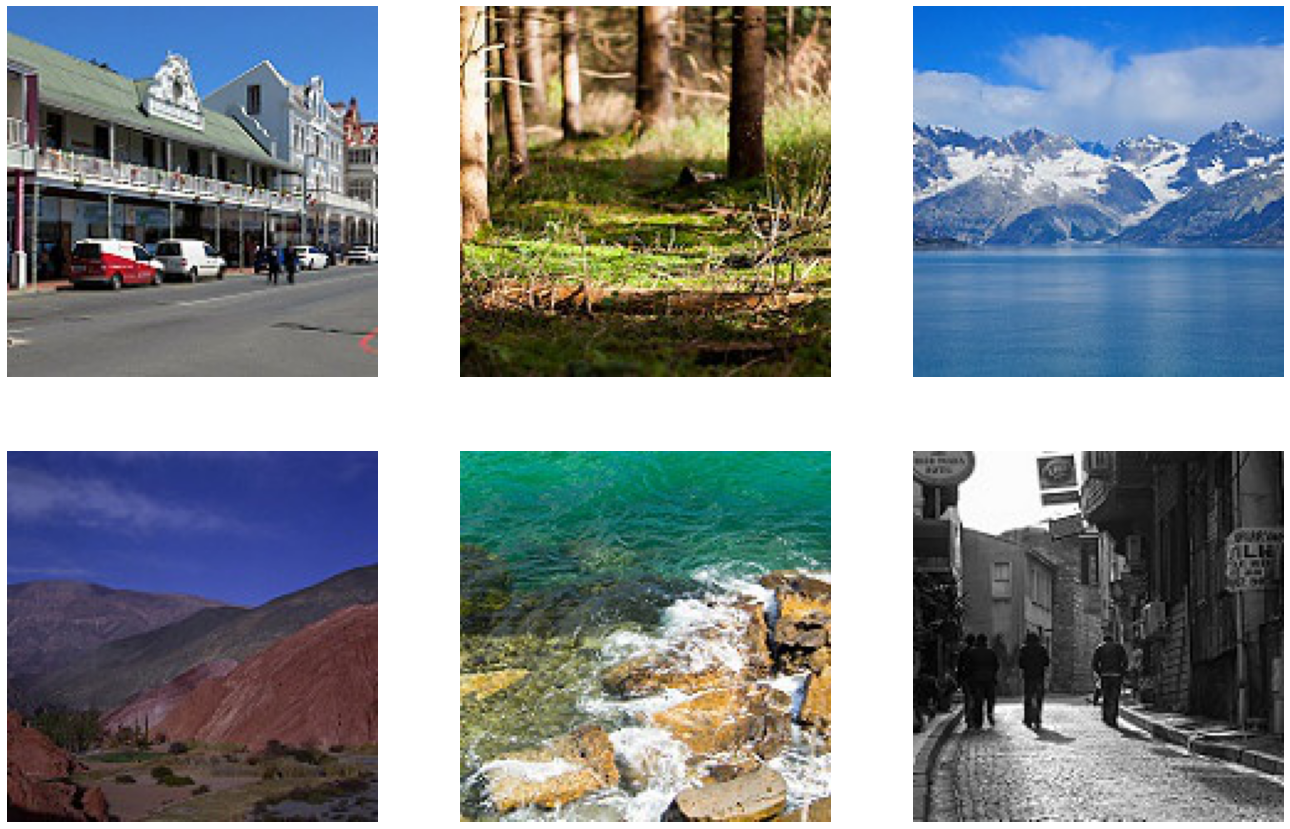

In [10]:
#@title Wybierz indeks przykładowego zdjęcia ze zbioru treningowego:

buildings_idx = 371 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(buildings_files_names))
img_path = os.path.join(train_buildings_dir, names_mapping[buildings_idx])
img_buildings = image.load_img(img_path)

forest_idx = 1302 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(forest_files_names))
img_path = os.path.join(train_forest_dir, names_mapping[forest_idx])
img_forest = image.load_img(img_path)

glacier_idx = 122 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(glacier_files_names))
img_path = os.path.join(train_glacier_dir, names_mapping[glacier_idx])
img_glacier = image.load_img(img_path)

mountain_idx = 1437 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(mountain_files_names))
img_path = os.path.join(train_mountain_dir, names_mapping[mountain_idx])
img_mountain = image.load_img(img_path)

sea_idx = 980 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(sea_files_names))
img_path = os.path.join(train_sea_dir, names_mapping[sea_idx])
img_sea = image.load_img(img_path)

street_idx = 171 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(street_files_names))
img_path = os.path.join(train_street_dir, names_mapping[street_idx])
img_street = image.load_img(img_path)

fig, ax = plt.subplots(2,3,figsize=(23, 15))

ax[0,0].imshow(img_buildings)
ax[0,1].imshow(img_forest)
ax[0,2].imshow(img_glacier)

ax[1,0].imshow(img_mountain)
ax[1,1].imshow(img_sea)
ax[1,2].imshow(img_street)


ax[0,0].axis(False)
ax[0,1].axis(False)
ax[0,2].axis(False)

ax[1,0].axis(False)
ax[1,1].axis(False)
ax[1,2].axis(False)

plt.show()

In [11]:
# Augmentacja danych

train_datagen = ImageDataGenerator(
    rotation_range=10,                                        # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,                                          # przeskalowujemy wszystkie obrazy o współczynnik 1/255
    width_shift_range=0.1,                                    # pionowe przekształcenia obrazu 
    height_shift_range=0.1,                                   # poziome przekształcenia obrazu
    shear_range=0.2,                                          # zares losowego przycianania obrazu
    zoom_range=0.1,                                           # zakres losowego przybliżania obrazu
    horizontal_flip=True,                                     # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'                                       # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

valid_datagen = ImageDataGenerator(rescale=1./255.) 


# Budujemy generatory
train_generator = train_datagen.flow_from_directory(directory=train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')  # batch size 32
valid_generator = valid_datagen.flow_from_directory(directory=valid_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')                                           

Found 11040 images belonging to 6 classes.
Found 4410 images belonging to 6 classes.


In [0]:
def display_augmented_images(directory, index):

    files_names = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = files_names[index]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)
    
    plt.figure(figsize=(23, 10))

    image_no = 1
    for batch in train_datagen.flow(x, batch_size=1):
        if image_no == 16:
            break      
        plt.subplot(3, 5, image_no)
        plt.axis(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        image_no += 1


In [0]:
buildings_index = 311 #@param {type:'slider', min:0, max:1839}  
display_augmented_images(train_buildings_dir, buildings_index)

#@title Zbiór treningowy forest:
forest_index = 458 #@param {type:'slider', min:0, max:1839}  
display_augmented_images(train_forest_dir, forest_index)

glacier_index = 174 #@param {type:'slider', min:0, max:1839}  
display_augmented_images(train_glacier_dir, glacier_index)

mountain_index = 77 #@param {type:'slider', min:0, max:1839}  
display_augmented_images(train_mountain_dir, mountain_index)

sea_index = 839 #@param {type:'slider', min:0, max:1839}  
display_augmented_images(train_sea_dir, sea_index)

street_index = 635 #@param {type:'slider', min:0, max:1839}  
display_augmented_images(train_street_dir, street_index)

In [0]:
class Network:
  
  def __init__(self, model_name, epochs, optimizer):
      self.model_name = model_name
      self.epochs = epochs
      self.optimizer = optimizer
      self.tz = 'CEST'

  def model_summary(self):
      self.model_name.summary()

  def save_model(self, file_name):
      self.models_dir = '/content/drive/My Drive/ColabNotebooks/intel_image/models/' + dt.now().strftime('%Y-%m-%d/')
      if not os.path.exists(self.models_dir):
        os.makedirs(self.models_dir)
      self.model_name.save(self.models_dir + file_name + '.h5')

  def train(self, verbose=0, ):

      self.model_name.compile(optimizer= self.optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
       
      log_dir = 'logs/' + dt.now().strftime('%Y-%m-%d_%H:%M:%S'+ self.tz) 
      tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1 )
      # --------------------------------------------------------
      time_start = time.time()
      self.history = self.model_name.fit( train_generator, steps_per_epoch= steps_per_epoch, epochs= self.epochs,
                          validation_data= valid_generator, validation_steps= validation_steps,
                          verbose= verbose, callbacks= [tensorboard, checkpoint]
                          )
      time_stop = time.time()
      print()
      print('Czas trenowania sieci: {} sek'.format(time_stop - time_start))
      # --------------------------------------------------------
      self.scores = self.model_name.evaluate(valid_generator, steps=validation_steps, verbose=0)
      print('Loss: {:.4f}'.format(self.scores[0]) )
      print('Accuracy: {:.4f}'.format(self.scores[1]) )

  def plot_hist(self, title):
      self.metric = 'accuracy'
      self.val_metric = 'val_accuracy'
      self.score = self.scores[1]

      sns.set_style("darkgrid")
      fig, axes = plt.subplots(1,2, figsize=(27,5))
      fig.suptitle(title)

      for self.i in range(2):
        if self.i == 1:
           self.metric = 'loss'
           self.val_metric = 'val_loss'
           self.score = self.scores[0]
        axes[self.i].plot(self.history.history[ self.val_metric], label= self.val_metric)
        axes[self.i].plot(self.history.history[ self.metric], label=  self.metric)
        axes[self.i].set(xlabel='epoki', ylabel= self.metric, title= self.metric+f': {self.score:.4f}')  
        axes[self.i].legend(loc='best')
      plt.show()

In [0]:
!rm -rf ./logs

path ='/content/drive/My Drive/ColabNotebooks/intel_image/model/kopia/best_model.hdf5' 

checkpoint = ModelCheckpoint(filepath=path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=80)

batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

# Modele

In [0]:
def Conv2D_block(y, number_of_layers, filters, kernel_size):

  for i in range(number_of_layers):
    y = Conv2D(filters= filters, kernel_size= kernel_size, activation='relu', padding='same')(y)
    y = BatchNormalization()(y)
  return y

## MODEL 1

In [0]:
# ------------------------MODEL 1-------------------------------
visible = Input(shape=(150, 150, 3))

y = Conv2D_block(visible, number_of_layers= 1, filters=32, kernel_size=5)
y = Conv2D_block(y, number_of_layers= 1, filters=32, kernel_size=3)
y = MaxPooling2D(pool_size=2)(y)

y = Conv2D_block(y, number_of_layers= 3, filters=32, kernel_size=3)
y = MaxPooling2D(pool_size=2)(y)

y = Conv2D_block(y, number_of_layers= 4, filters=32, kernel_size=3)

y = Conv2D_block(y, number_of_layers= 1, filters=32, kernel_size=1)
y = Conv2D_block(y, number_of_layers= 1, filters=32, kernel_size=3)
y = Conv2D_block(y, number_of_layers= 1, filters=64, kernel_size=1)
y = MaxPooling2D(pool_size=2)(y)

y = Conv2D_block(y, number_of_layers= 8, filters=64, kernel_size=3)
y = MaxPooling2D(pool_size=2)(y)

y = Conv2D_block(y, number_of_layers= 8, filters=64, kernel_size=3)
y = MaxPooling2D(pool_size=2)(y)

y = Conv2D_block(y, number_of_layers= 8, filters=64, kernel_size=3)
y = MaxPooling2D(pool_size=2)(y)


y = GlobalAveragePooling2D()(y)
y = Dropout(0.5)(y)
output = Dense(6, activation='softmax')(y)

model_1 = Model(inputs=visible, outputs=output)

In [17]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        9248  

## MODEL 2

In [0]:
# ------------------------MODEL 2-------------------------------
visible = Input(shape=(150, 150, 3))

y = Conv2D_block(visible, number_of_layers= 1, filters= 32, kernel_size=5)
y = Conv2D_block(y, number_of_layers= 2, filters= 32, kernel_size=3)
y = MaxPooling2D(pool_size=2)(y)

y = Conv2D_block(y, number_of_layers= 3, filters= 32, kernel_size=3)
y = MaxPooling2D(pool_size=2)(y)

y = Conv2D_block(y, number_of_layers= 5, filters= 32, kernel_size=3)
y = MaxPooling2D(pool_size=2)(y)

y = Conv2D_block(y, number_of_layers= 3, filters= 64, kernel_size=3)
y = MaxPooling2D(pool_size=2)(y)

y = Conv2D_block(y, number_of_layers= 1, filters= 64, kernel_size=1)
y = Conv2D_block(y, number_of_layers= 1, filters= 64, kernel_size=3)
y = Conv2D_block(y, number_of_layers= 1, filters= 128, kernel_size=1)
y = MaxPooling2D(pool_size=2)(y)

y = Conv2D_block(y, number_of_layers= 8, filters= 128, kernel_size=3)
y = MaxPooling2D(pool_size=2)(y)



y = GlobalAveragePooling2D()(y)
y = Dropout(0.5)(y)
output = Dense(6, activation='softmax')(y)

model_2 = Model(inputs=visible, outputs=output)

In [19]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 150, 150, 32)      2432      
_________________________________________________________________
batch_normalization_36 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_37 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_38 (Batc (None, 150, 150, 32)      128 

## MODEL 3

In [0]:
visible = Input(shape=(150, 150, 3))

y1 = MaxPooling2D(pool_size= 2)(visible) 
y1 = Conv2D_block(y1, number_of_layers= 1, filters= 32, kernel_size= 5)
y1 = Conv2D_block(y1, number_of_layers= 1, filters= 32, kernel_size= 3)
y1 = Conv2D_block(y1, number_of_layers= 1, filters= 64, kernel_size= 3)

y2 = Conv2D_block(visible, number_of_layers= 1, filters= 32, kernel_size= 5)
y2 = Conv2D_block(y2, number_of_layers= 3, filters= 32, kernel_size=3)
y2 = MaxPooling2D(pool_size= 2)(y2)

y3 = Conv2D_block(visible, number_of_layers= 1, filters= 32, kernel_size= 3)
y3 = Conv2D_block(y3, number_of_layers= 2, filters= 32, kernel_size= 3)
y3 = MaxPooling2D(pool_size= 2)(y3)

y4 = Conv2D_block(visible, number_of_layers= 1, filters= 32, kernel_size= 1)
y4 = Conv2D_block(y4, number_of_layers= 1, filters= 32, kernel_size= 3)
y4 = Conv2D_block(y4, number_of_layers= 3, filters= 64, kernel_size= 1)
y4 = MaxPooling2D(pool_size= 2)(y4)

y5 = concatenate([y1, y2, y3, y4])

y6 = MaxPooling2D(pool_size=2)(y5)
y6 = Conv2D_block(y6, number_of_layers= 3, filters= 32, kernel_size= 3)
y6 = Conv2D_block(y6, number_of_layers= 1, filters= 32, kernel_size= 1)
y6 = Conv2D_block(y6, number_of_layers= 1, filters= 32, kernel_size= 3)
y6 = Conv2D_block(y6, number_of_layers= 1, filters= 128, kernel_size= 1)

y7 = Conv2D_block(y5, number_of_layers= 1, filters= 32, kernel_size= 1)
y7 = Conv2D_block(y7, number_of_layers= 1, filters= 32, kernel_size= 3)
y7 = Conv2D_block(y7, number_of_layers= 1, filters= 64, kernel_size= 1)
y7 = MaxPooling2D(pool_size=2)(y7)

y8 = Conv2D_block(y5, number_of_layers= 1, filters= 32, kernel_size= 1)
y8 = Conv2D_block(y8, number_of_layers= 1, filters= 32, kernel_size= 3)
y8 = Conv2D_block(y8, number_of_layers= 1, filters= 128, kernel_size= 1)
y8 = MaxPooling2D(pool_size=2)(y8)

y9 = Conv2D_block(y5, number_of_layers= 1, filters= 32, kernel_size= 1)
y9 = Conv2D_block(y9, number_of_layers= 1, filters= 32, kernel_size= 3)
y9 = Conv2D_block(y9, number_of_layers= 1, filters= 64, kernel_size= 1)
y9 = Conv2D_block(y9, number_of_layers= 1, filters= 64, kernel_size= 3)
y9 = MaxPooling2D(pool_size=2)(y9)

y10 = concatenate([y6, y7, y8, y9])

y11 = Conv2D_block(y10, number_of_layers= 2, filters= 32, kernel_size= 3)
y11 = Conv2D_block(y11, number_of_layers= 1, filters= 64, kernel_size= 3)
y11 = MaxPooling2D(pool_size=2)(y11)

y12 = Conv2D_block(y10, number_of_layers= 2, filters= 32, kernel_size= 3)
y12 = MaxPooling2D(pool_size=2)(y12)

y13 = concatenate([y11, y12])

y14 = Conv2D_block(y13, number_of_layers= 2, filters= 32, kernel_size= 3)
y14 = Conv2D_block(y14, number_of_layers= 1, filters= 64, kernel_size= 3)
y14 = MaxPooling2D(pool_size=2)(y14)

y15 = Conv2D_block(y13, number_of_layers= 4, filters= 32, kernel_size= 3)
y15 = MaxPooling2D(pool_size=2)(y15)

y16 = concatenate([y14, y15])

y17 = Conv2D_block(y16, number_of_layers= 4, filters= 32, kernel_size= 3)
y17 = Conv2D_block(y17, number_of_layers= 2, filters= 64, kernel_size= 3)
y17 = MaxPooling2D(pool_size=2)(y17)

y18 = Conv2D_block(y16, number_of_layers= 4, filters= 32, kernel_size= 3)
y18 = Conv2D_block(y18, number_of_layers= 1, filters= 64, kernel_size= 3)

y19 = concatenate([y14, y15])

y20 = Conv2D_block(y19, number_of_layers= 4, filters= 32, kernel_size= 3)
y20 = Conv2D_block(y20, number_of_layers= 2, filters= 64, kernel_size= 3)

y21 = Conv2D_block(y19, number_of_layers= 4, filters= 64, kernel_size= 3)
y21 = Conv2D_block(y21, number_of_layers= 4, filters= 64, kernel_size= 3)


y = concatenate([y20, y21])

y = GlobalAveragePooling2D()(y)
y = Dropout(0.5)(y)
output = Dense(6, activation='softmax')(y)

model_3 = Model(inputs=visible, outputs=output)

In [21]:
model_3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 150, 150, 32) 128         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_71 (BatchNo (None, 150, 150, 32) 128         conv2d_71[0][0]                  
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 150, 150, 32) 2432        input_3[0][0]                    
____________________________________________________________________________________________

## MODEL 4

In [0]:
# ------------------------MODEL 4-------------------------------
visible = Input(shape=(150, 150, 3))

y = Conv2D_block(visible, number_of_layers= 1, filters= 32, kernel_size= 5)
y = Conv2D_block(y, number_of_layers= 1, filters= 32, kernel_size= 3)
y = MaxPooling2D(pool_size= 2)(y)

y = Conv2D_block(y, number_of_layers= 4, filters= 32, kernel_size= 3)
y = Conv2D_block(y, number_of_layers= 4, filters= 64, kernel_size= 3)
y = MaxPooling2D(pool_size= 2)(y)


y = Conv2D_block(y, number_of_layers= 8, filters= 128, kernel_size= 3)
y = MaxPooling2D(pool_size= 2)(y)

y = Conv2D_block(y, number_of_layers= 2, filters= 32, kernel_size= 1)
y = Conv2D_block(y, number_of_layers= 3, filters= 32, kernel_size= 3)
y = Conv2D_block(y, number_of_layers= 2, filters= 64, kernel_size= 1)
y = MaxPooling2D(pool_size= 2)(y)


y = Conv2D_block(y, number_of_layers= 4, filters= 64, kernel_size= 3)
y = MaxPooling2D(pool_size= 2)(y)

y = Conv2D_block(y, number_of_layers= 4, filters= 128, kernel_size= 3)
y = Conv2D_block(y, number_of_layers= 4, filters= 256, kernel_size= 3)


y = GlobalAveragePooling2D()(y)
y = Dropout(0.5)(y)
output = Dense(6, activation='softmax')(y)

model_4 = Model(inputs=visible, outputs=output)

In [23]:
model_4.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 150, 150, 32)      2432      
_________________________________________________________________
batch_normalization_129 (Bat (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_130 (Bat (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 75, 75, 32)        9248

## MODEL 5

In [0]:
# ------------------------MODEL 5-------------------------------
visible = Input(shape=(150, 150, 3))

y1 = Conv2D_block(visible, number_of_layers= 1, filters= 32, kernel_size= 5)
y1 = Conv2D_block(y1, number_of_layers= 1, filters= 32, kernel_size= 3)
y1 = Conv2D_block(y1, number_of_layers= 2, filters= 64, kernel_size= 1)
y1 = MaxPooling2D(pool_size= 2)(y1)

y2 = Conv2D_block(visible, number_of_layers= 1, filters= 32, kernel_size= 5)
y2 = Conv2D_block(y2, number_of_layers= 3, filters= 32, kernel_size= 3)
y2 = Conv2D_block(y2, number_of_layers= 1, filters= 32, kernel_size= 1)
y2 = Conv2D_block(y2, number_of_layers= 1, filters= 32, kernel_size= 3)
y2 = Conv2D_block(y2, number_of_layers= 1, filters= 128, kernel_size= 1)
y2 = MaxPooling2D(pool_size= 2)(y2)

y3 = MaxPooling2D(pool_size=(2, 2))(visible)
y3 = Conv2D_block(y3, number_of_layers= 1, filters= 32, kernel_size= 1)
y3 = Conv2D_block(y3, number_of_layers= 1, filters= 32, kernel_size= 3)
y3 = Conv2D_block(y3, number_of_layers= 3, filters= 64, kernel_size= 1)

y4 = concatenate([y1, y2, y3])

y5 = Conv2D_block(y4, number_of_layers= 1, filters= 32, kernel_size= 1)
y5 = Conv2D_block(y5, number_of_layers= 2, filters= 32, kernel_size= 3)
y5 = MaxPooling2D(pool_size= 2)(y5)
y5 = Conv2D_block(y5, number_of_layers= 3, filters= 64, kernel_size= 3)
y5 = MaxPooling2D(pool_size= 2)(y5)

y6 = Conv2D_block(y4, number_of_layers= 3, filters= 32, kernel_size= 3)
y6 = Conv2D_block(y6, number_of_layers= 1, filters= 32, kernel_size= 1)
y6 = Conv2D_block(y6, number_of_layers= 1, filters= 32, kernel_size= 3)
y6 = Conv2D_block(y6, number_of_layers= 1, filters= 64, kernel_size= 1)
y6 = MaxPooling2D(pool_size= 2)(y6)
y6 = Conv2D_block(y6, number_of_layers= 2, filters= 64, kernel_size= 3)
y6 = MaxPooling2D(pool_size= 2)(y6)

y7 = concatenate([y5, y6])

y7 = MaxPooling2D(pool_size= 2)(y7)

y8 = Conv2D_block(y7, number_of_layers= 3, filters= 32, kernel_size= 3)
y8 = Conv2D_block(y8, number_of_layers= 5, filters= 64, kernel_size= 1)


y9 = Conv2D_block(y7, number_of_layers= 2, filters= 64, kernel_size= 3)


y10 = concatenate([y8, y9])

y11 = Conv2D_block(y10, number_of_layers= 2, filters= 16, kernel_size= 3)
y11 = Conv2D_block(y11, number_of_layers= 4, filters= 32, kernel_size= 3)
y11 = Conv2D_block(y11, number_of_layers= 4, filters= 64, kernel_size= 3)
y11 = MaxPooling2D(pool_size= 2)(y11)

y12 = Conv2D_block(y10, number_of_layers= 4, filters= 32, kernel_size= 3)
y12 = Conv2D_block(y12, number_of_layers= 6, filters= 64, kernel_size= 3)
y12 = MaxPooling2D(pool_size= 2)(y12)

y13 = Conv2D_block(y10, number_of_layers= 3, filters= 64, kernel_size= 3)
y13 = Conv2D_block(y13, number_of_layers= 4, filters= 128, kernel_size= 3)
y13 = Conv2D_block(y13, number_of_layers= 4, filters= 256, kernel_size= 3)
y13 = MaxPooling2D(pool_size= 2)(y13)

y = concatenate([y11, y12, y13])


y = GlobalAveragePooling2D()(y)
y = Dropout(0.5)(y)
output = Dense(6, activation='softmax')(y)

model_5 = Model(inputs=visible, outputs=output)

In [25]:
model_5.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_170 (Conv2D)             (None, 150, 150, 32) 2432        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_170 (BatchN (None, 150, 150, 32) 128         conv2d_170[0][0]                 
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 150, 150, 32) 9248        batch_normalization_170[0][0]    
____________________________________________________________________________________________

# Utworzenie obiektów

In [0]:
modelObj_1 = Network(model_1, epochs=100, optimizer=Adam(lr=1e-4))
modelObj_2 = Network(model_2, epochs=100, optimizer=Adam(lr=1e-4))
modelObj_3 = Network(model_3, epochs=100, optimizer=Adam(lr=1e-4))
modelObj_4 = Network(model_4, epochs=100, optimizer=Adam(lr=1e-4))
modelObj_5 = Network(model_5, epochs=100, optimizer=Adam(lr=1e-4))

# Trenowanie sieci

In [29]:
modelObj_1.train(verbose=0)


Czas trenowania sieci: 1052.9077055454254 sek
Loss: 0.9743
Accuracy: 0.6321


In [30]:
modelObj_2.train(verbose=0)


Czas trenowania sieci: 1062.3693072795868 sek
Loss: 0.6091
Accuracy: 0.7855


In [28]:
modelObj_3.train(verbose=0)


Czas trenowania sieci: 1431.425000667572 sek
Loss: 0.4594
Accuracy: 0.8452


In [31]:
modelObj_4.train(verbose=0)


Czas trenowania sieci: 1102.1424372196198 sek
Loss: 0.7325
Accuracy: 0.7216


In [32]:
modelObj_5.train(verbose=0)


Czas trenowania sieci: 1409.7873840332031 sek
Loss: 0.5532
Accuracy: 0.8139


# Zapisanie modeli

In [0]:
# modelObj_1.save_model('model_1_L0.53_A0.80')
# modelObj_2.save_model('model_2_L0.55_A0.78')
# modelObj_3.save_model('model_3_L0.36_A0.86')
# modelObj_4.save_model('model_4')
modelObj_5.save_model('model_5_L0.55_A0.81')

## Charakterystyki trenowanych modeli

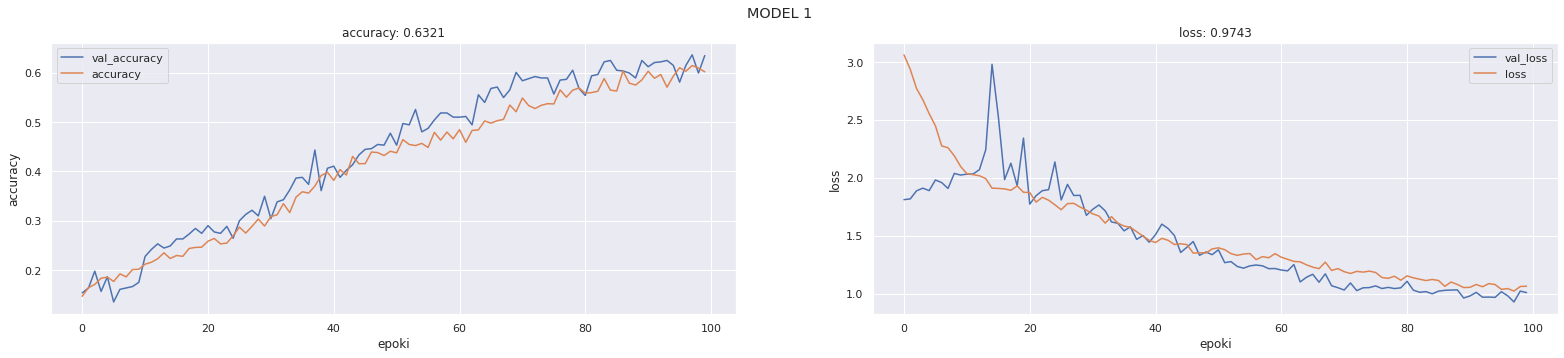

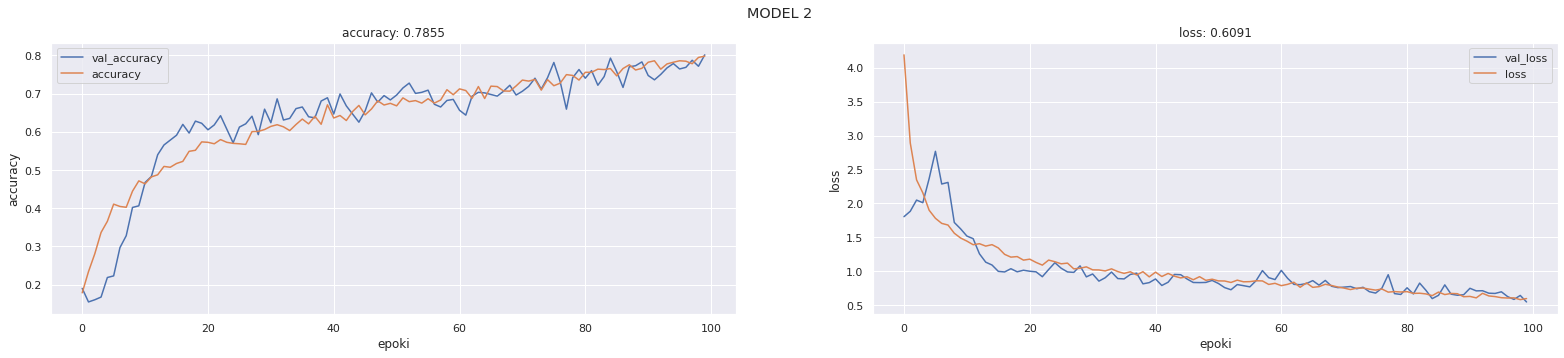

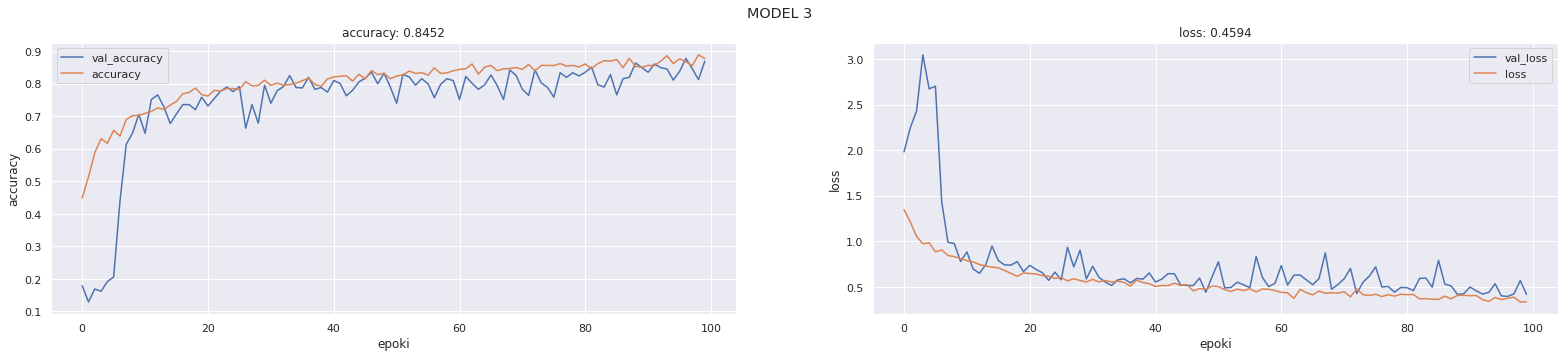

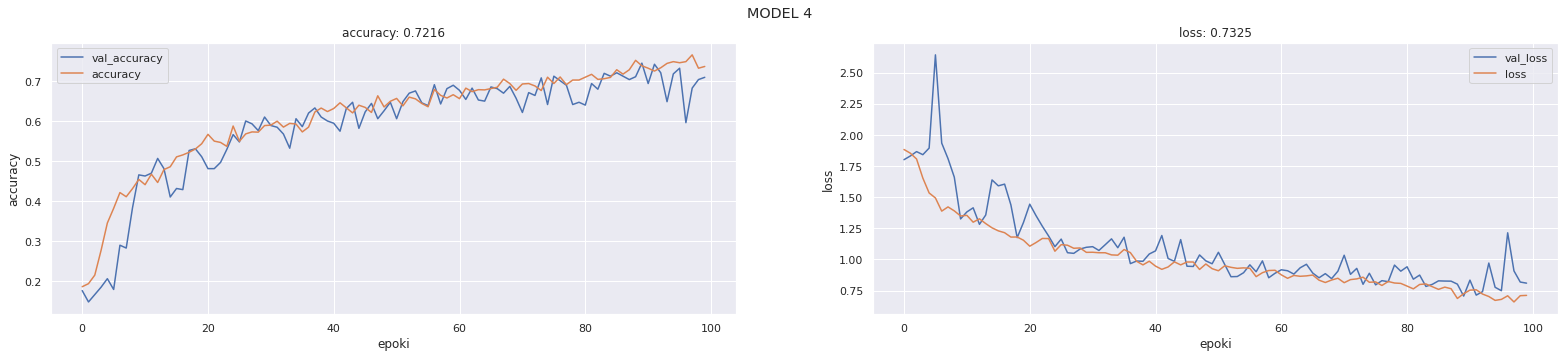

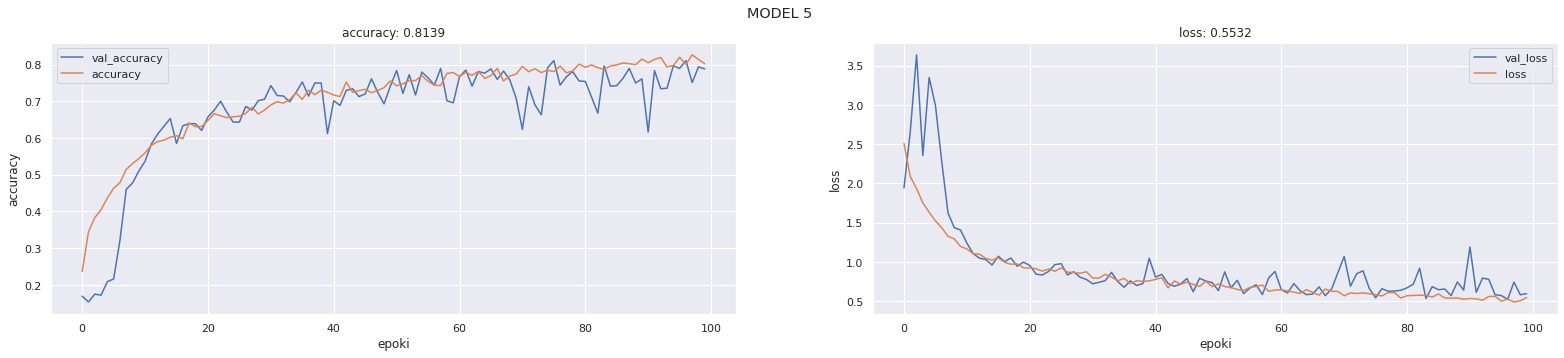

In [34]:
modelObj_1.plot_hist(title='MODEL 1')
modelObj_2.plot_hist(title='MODEL 2')
modelObj_3.plot_hist(title='MODEL 3')
modelObj_4.plot_hist(title='MODEL 4')
modelObj_5.plot_hist(title='MODEL 5')

In [0]:
# %tensorboard --logdir logs

# Testowanie modelu

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255.) 
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=32, class_mode='categorical', shuffle=False )

Found 318 images belonging to 6 classes.


In [0]:
best_model = load_model('/content/drive/My Drive/ColabNotebooks/intel_image/models/2020-06-03/model_3_L0.44_A0.83.h5') # 41 errors

best_model.summary()

In [0]:
y_proba = model_3.predict(test_generator, steps=len(test_generator), batch_size=32 ) 

# Nasza predykcja zwraca nam prawdopobieństwa przynależności do każdej z klas
y_proba

array([[0.23277497    , 0.015376543   , 0.15601236    , 0.06817509    ,
        0.51530176    , 0.012359286   ],
       [0.99524754    , 0.000039021008, 0.000025373301, 0.000028995546,
        0.00002169174 , 0.0046374146  ],
       [0.93514305    , 0.0024162845  , 0.000038432467, 0.0006711587  ,
        0.00039487443 , 0.061336208   ],
       ...,
       [0.03657409    , 0.0038912287  , 0.0003393098  , 0.0033838449  ,
        0.001154362   , 0.9546572     ],
       [0.0012255147  , 0.012965556   , 0.00017662364 , 0.000021069553,
        0.0008616166  , 0.98474956    ],
       [0.056571245   , 0.00053777144 , 0.000021892725, 0.00006382084 ,
        0.00009965627 , 0.9427056     ]], dtype=float32)

In [0]:
# Meotoda argmax() zwróci nam pozycje, gdzie w tablicy jest wartość max.
y_pred = np.argmax(y_proba, axis=1)
print('y_pred:\n', y_pred)

print()
# Prawdziwe klasy, które były przypisane do naszego zbioru testowego
y_true = test_generator.classes
print('y_true:\n', y_true)

y_pred:
 [4 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 5
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 2 2 3 4
 2 2 2 3 2 2 2 2 2 2 2 3 0 4 2 3 2 2 2 2 2 3 2 2 2 4 3 3 2 2 3 3 4 2 2 0 2
 2 3 3 2 2 2 2 2 2 3 1 2 2 3 3 3 3 3 3 2 3 3 3 3 2 3 3 3 3 3 3 2 3 3 3 3 3
 3 3 3 3 2 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 4 3 3 3 3 3 0 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 4 4 4 4 4 3 4 4 4 4 4 3 4 4 2 4
 4 4 4 4 4 4 5 0 5 5 5 0 5 5 5 5 0 0 5 5 5 5 0 5 5 5 5 5 5 5 5 5 5 5 5 0 5
 5 1 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5]

y_true:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 

In [0]:
test_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

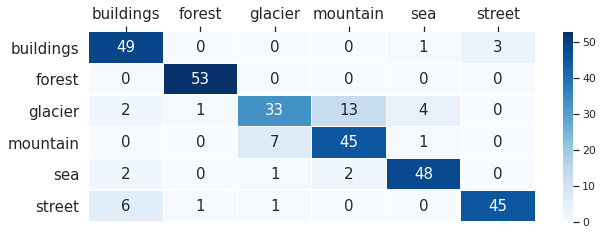

In [0]:
# Tworzymy macierz konfucji, która powie nam jak wygląda klasyfikacja

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 3.5))
g = sns.heatmap(cm, annot=True, fmt='d', linewidth=.2, cmap='Blues',
                xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys(),
                annot_kws={"size": 15})

g.tick_params(labelsize=15)
g.xaxis.tick_top()
plt.yticks(rotation=0) 
plt.xticks(rotation=0) 
plt.show()

In [0]:
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

   buildings       0.83      0.92      0.88        53
      forest       0.96      1.00      0.98        53
     glacier       0.79      0.62      0.69        53
    mountain       0.75      0.85      0.80        53
         sea       0.89      0.91      0.90        53
      street       0.94      0.85      0.89        53

    accuracy                           0.86       318
   macro avg       0.86      0.86      0.86       318
weighted avg       0.86      0.86      0.86       318



In [0]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'incorrect':  (y_true != y_pred) * 1}, index=test_generator.filenames)
errors.head()

,y_true,y_pred,incorrect
buildings/10018.jpg,0,4,1
buildings/10126.jpg,0,0,0
buildings/11378.jpg,0,0,0
buildings/12513.jpg,0,0,0
buildings/12719.jpg,0,0,0


In [0]:
len(errors[errors['incorrect'] == 1].index)

45

In [0]:
# obiekty błędnie sklasyfikowane
errors[errors['incorrect'] == 1].index

Index(['buildings/10018.jpg', 'buildings/1471.jpg', 'buildings/2202.jpg',
       'buildings/23733.jpg', 'glacier/10094.jpg', 'glacier/10808.jpg',
       'glacier/11280.jpg', 'glacier/12342.jpg', 'glacier/15889.jpg',
       'glacier/16467.jpg', 'glacier/16710.jpg', 'glacier/17361.jpg',
       'glacier/19667.jpg', 'glacier/20815.jpg', 'glacier/2125.jpg',
       'glacier/214.jpg', 'glacier/22964.jpg', 'glacier/23169.jpg',
       'glacier/23801.jpg', 'glacier/24171.jpg', 'glacier/4476.jpg',
       'glacier/6421.jpg', 'glacier/8636.jpg', 'glacier/910.jpg',
       'mountain/10214.jpg', 'mountain/10264.jpg', 'mountain/15094.jpg',
       'mountain/16473.jpg', 'mountain/20662.jpg', 'mountain/24264.jpg',
       'mountain/7060.jpg', 'mountain/7715.jpg', 'sea/10122.jpg',
       'sea/23045.jpg', 'sea/4097.jpg', 'sea/5716.jpg', 'sea/6387.jpg',
       'street/10697.jpg', 'street/1121.jpg', 'street/12822.jpg',
       'street/12958.jpg', 'street/14482.jpg', 'street/20653.jpg',
       'street/21800.jpg'

In [0]:
test_dir_list = [test_buildings_dir, test_forest_dir, test_glacier_dir, test_mountain_dir, test_sea_dir, test_street_dir]
  
fig = plt.figure(figsize=(30, 20))
fig.subplots_adjust(hspace=0.3, wspace=0)

rows= 5
cols= 8
col_idx = 0

for i in range(1, 40):
  img = [ img.split('/')[1] for i, img in enumerate(errors[errors['incorrect'] == 1].index) ][col_idx]
  category = [ img.split('/')[0] for i, img in enumerate(errors[errors['incorrect'] == 1].index) ][col_idx]
  pred_label = [pred_label for i, pred_label in enumerate(errors[errors['incorrect'] == 1]['y_pred'].values) ][col_idx]
  true_label = [true_label for i, true_label in enumerate(errors[errors['incorrect'] == 1]['y_true'].values) ][col_idx]

  for key, val in test_generator.class_indices.items():
    if val == pred_label:
       pred_label = key
    if val == true_label:
       true_label = key   

  dir_name = test_dir + '/'+ category

  fig.add_subplot(rows, cols, i)
  img_path = os.path.join(dir_name, img) 

  img = image.load_img(img_path)

  plt.imshow(img)
  plt.title(f'true label: {true_label}\n predicted: {pred_label}', fontdict = {'color' : 'green', 'weight' : 'bold', 'size' : 12})
  plt.axis('off')
  col_idx += 1

plt.show()

In [0]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(f'Working on device={device}')

Working on device=cuda


In [0]:
transform = transforms.Compose(
    [
     transforms.Resize ( (150 , 150) ), # resize each image to a 150x150
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



batch_size=32

trainset = datasets.ImageFolder(root= train_dir, transform=transform )
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

validnset = datasets.ImageFolder(root= valid_dir, transform=transform )
valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)



testset = datasets.ImageFolder(root= test_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [0]:
trainset.class_to_idx

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) # 150 / 2 = 75
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) 

        
        self.lf = nn.Linear(in_features=64*4*4, out_features=6)
    
    def forward(self, input):
        x = self.conv1(input)
        x = self.relu1(x)
        
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = output.view(x.size(0),-1)

        x = self.lf(x)

        return x

In [0]:
model = CNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lf): Linear(in_features=1024, out_features=6, bias=True)
)
